# Regressor Chain

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from notebook_utils import run_xgb_model, scores_barplot, \
    plot_feature_imps, run_lin_reg_model, print_results, run_models, mo_reg_scorer
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import RegressorChain
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)
sns.set_theme(style="whitegrid")

## Import & Prepare Data

In [2]:
# Load dataset from csv
data = pd.read_csv("..\\data\\dataset-merged.csv")
# Drop unwanted columns
data.drop(['sheepid'], axis=1, inplace=True)
data.drop(['slaughgr'], axis=1, inplace=True)
print(data.head())

# Split independent variables from target variables
input_cols = ['breed', 'sex', 'slweight(g)']
X = data[input_cols]
y = data.drop(input_cols, axis=1)
# print(X.columns)
print(pd.DataFrame(y.columns))

# Scale data
std_scaler = StandardScaler()
X = pd.DataFrame(std_scaler.fit_transform(X), columns=X.columns)
y = pd.DataFrame(std_scaler.fit_transform(y), columns=y.columns)

   breed  sex  slweight(g)  woolfr  blood  feet  pelt  fullGI  mesent  epipl  liver  spleen  pluck  head  warmcarc  kidney  KKCF  tail  coldcarc  mw%  WtBefDIS  LEG  CHUMP  LOIN  BREAST  BESTEND  MIDNECK  SHOULDER  NECK
0      1    1        12399     150    575   450  1250    1400     100    150    275      30    425   635      6850      32   122    32      6612   25      3280  820    307   336     323      236      477       665   110
1      1    1        12500     130    575   475  1245    1500      75     75    300      50    525   650      6800      32    78    32      6542   25      3180  803    298   322     290      242      454       682    94
2      1    1        12300     140    600   475  1200    1300     100    125    275      50    400   625      6875      32   118    44      6776   25      3350  812    350   328     316      238      500       670   130
3      1    1        12399     120    625   450  1225    1375     125    250    300      50    400   650      6850      

In [3]:
def print_scores(scores, regressor_title=''):
    print(regressor_title)
    print('R2 score:', scores['ua_score_r2'])
    print('MAE:', scores['ua_score_mae'])
    print('RMSE:', scores['ua_score_rmse'])
    print('MAPE:', scores['ua_score_mape'])
    print()

## Chain Regressors - Linear Regression vs XGBoost (Whole Dataset)

Με βάση τα σφάλματα των προβλέψεων που έκανε ο Linear Regression σε όλο το σύνολο δεδομένων (χωρίς train-test split)

Linear Regression Chain
R2 score: 0.9130050445427015
MAE: 0.19954223871802862
RMSE: 0.26673191865390466
MAPE: 0.7039686685469557



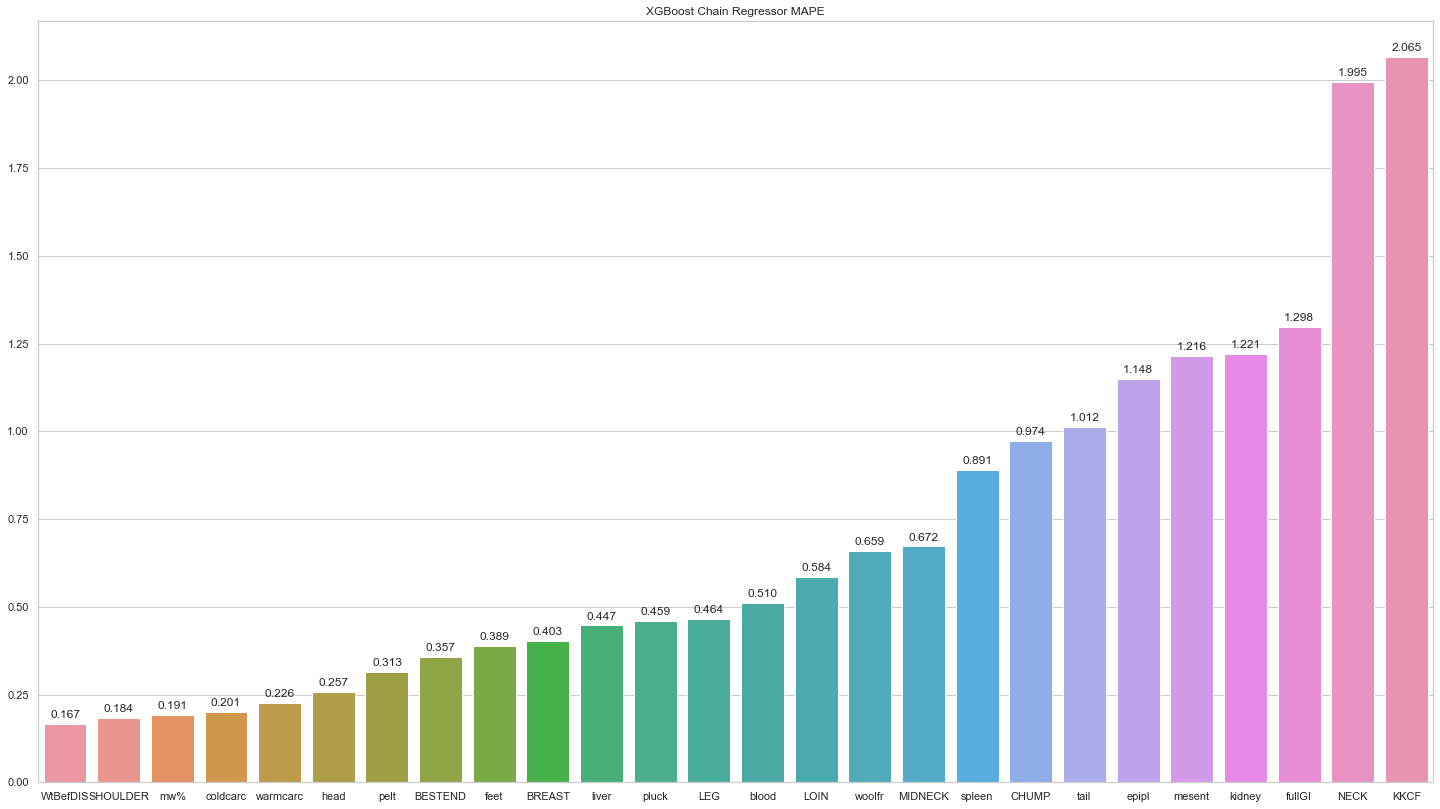

In [4]:
prediction_order = [17,24,16,15,11,10,3,22,2,21,7,9,18,1,20,0,23,8,19,14,6,5,12,4,25,13]
model = RegressorChain(LinearRegression(), order=prediction_order)
model.fit(X, y)
scores = mo_reg_scorer(model, X, y)

# Print model scores (uniform average)
print_scores(scores, 'Linear Regression Chain')
scores_barplot(scores['rv_scores_mape'], y.columns, title="XGBoost Chain Regressor MAPE")

XGBoost Chain
R2 score: 0.9697515186415165
MAE: 0.10088971451806451
RMSE: 0.15407589125774732
MAPE: 0.40471257844834113



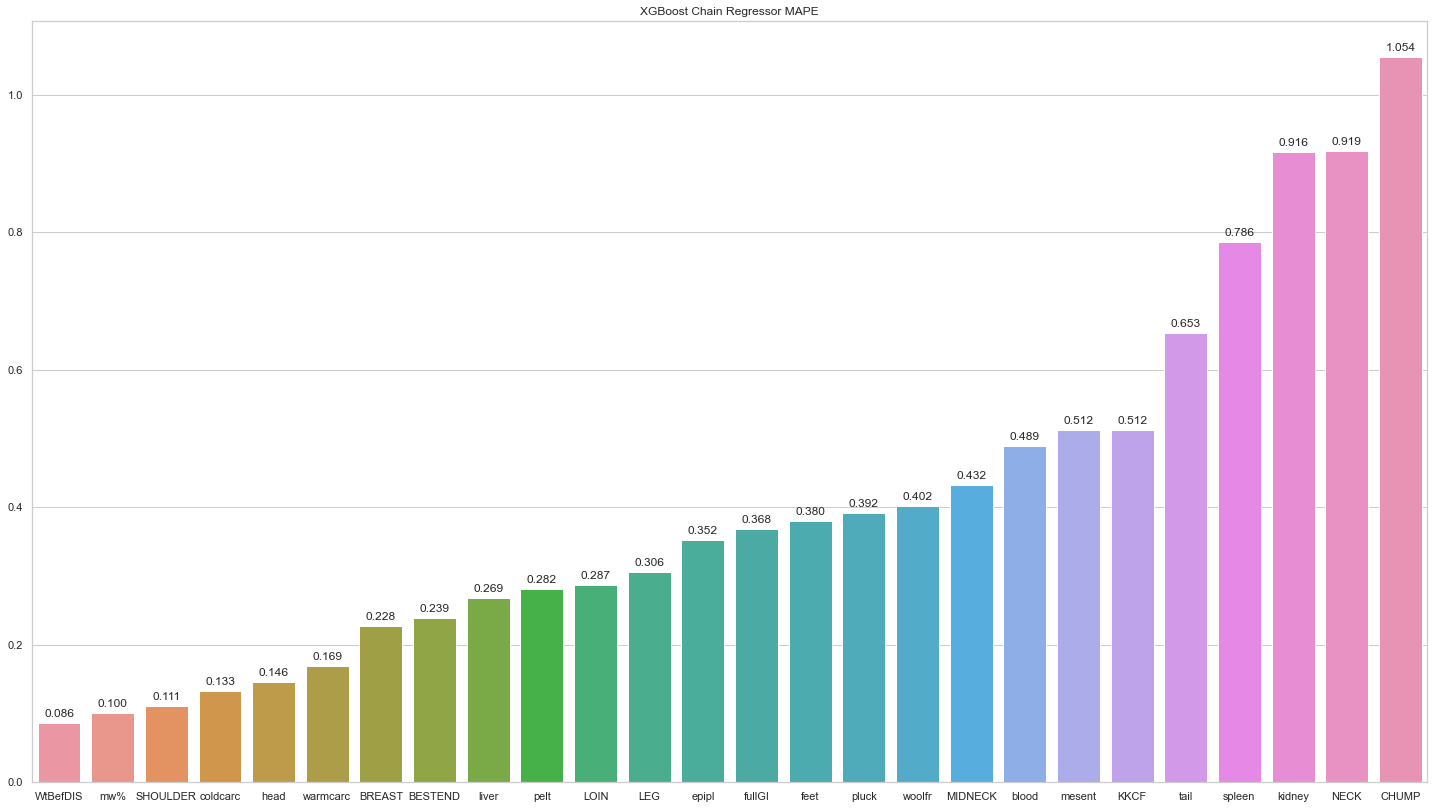

In [5]:
prediction_order = [16,17,24,15,11,10,3,21,1,20,7,22,6,0,2,23,9,18,4,5,8,14,25,12,19,13]
model = RegressorChain(xgb.XGBRegressor(colsample_bytree=0.5, learning_rate=0.1, max_depth=4,
                                        n_estimators=90, n_jobs=-1), order=prediction_order)
model.fit(X, y)
scores = mo_reg_scorer(model, X, y)

# Print model scores (uniform average)
print_scores(scores, 'XGBoost Chain')
scores_barplot(scores['rv_scores_mape'], y.columns, title="XGBoost Chain Regressor MAPE")

Χρησιμοποιώντας chain regressors και προβλέποντας τις μεταβλητές σε σειρά με βάση την ακρίβεια που επιτυγχάνεται στη κάθε
μία, παρατηρούμε μία μικρή μείωση στο MAPE και των δύο μοντέλων.

## Chain Regressors Performance On New Data

In [6]:
# Split train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=96)
# print('Train set shape:', X_train.shape, y_train.shape)
# print('Test set shape:', X_test.shape, y_test.shape)

### Train Set Performance

Linear Regression Chain
R2 score: 0.9198966465272373
MAE: 0.19780782166222746
RMSE: 0.26520940465375714
MAPE: 0.5808839118720677



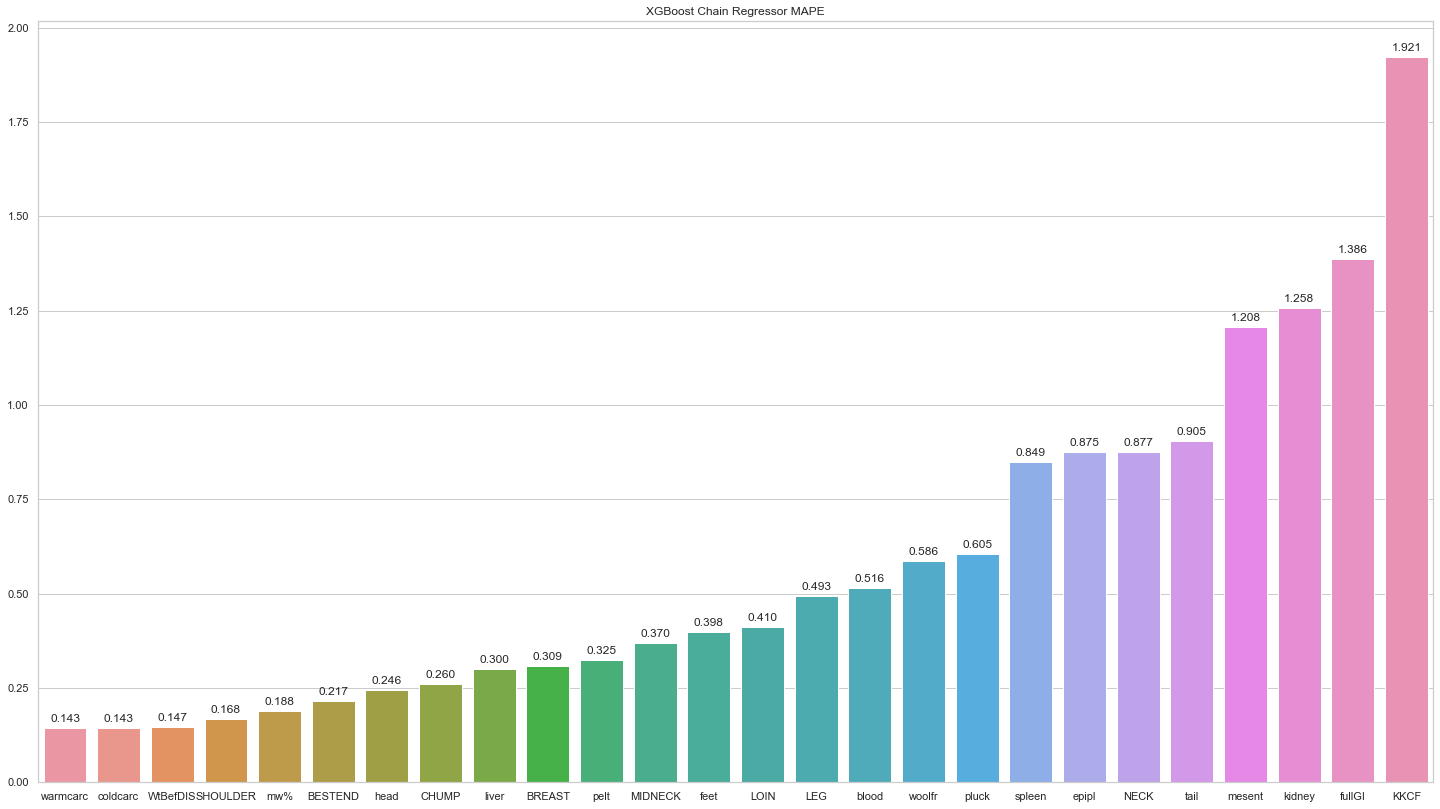

In [7]:
prediction_order = [17,24,16,15,11,10,3,22,2,21,7,9,18,1,20,0,23,8,19,14,6,5,12,4,25,13]
model = RegressorChain(LinearRegression(), order=prediction_order)
model.fit(X_train, y_train)
scores = mo_reg_scorer(model, X_train, y_train)

# Print model scores (uniform average)
print_scores(scores, 'Linear Regression Chain')
scores_barplot(scores['rv_scores_mape'], y.columns, title="XGBoost Chain Regressor MAPE")

XGBoost Chain
R2 score: 0.9748104084966412
MAE: 0.09111923729407259
RMSE: 0.1450901304755783
MAPE: 0.277325972769125



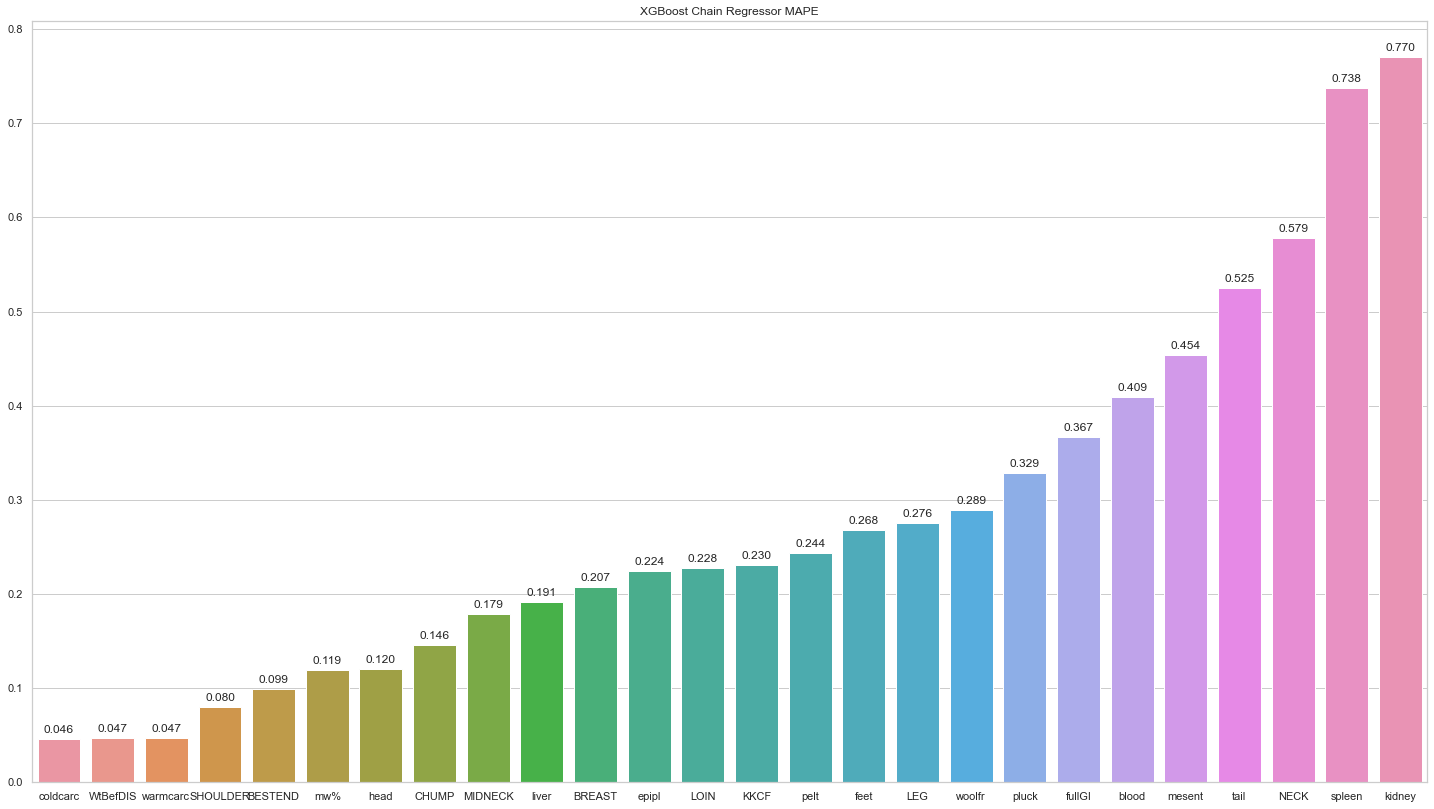

In [8]:
prediction_order = [16,17,24,15,11,10,3,21,1,20,7,22,6,0,2,23,9,18,4,5,8,14,25,12,19,13]
model = RegressorChain(xgb.XGBRegressor(colsample_bytree=0.5, learning_rate=0.1, max_depth=4,
                                        n_estimators=90, n_jobs=-1), order=prediction_order)
model.fit(X_train, y_train)
scores = mo_reg_scorer(model, X_train, y_train)

# Print model scores (uniform average)
print_scores(scores, 'XGBoost Chain')
scores_barplot(scores['rv_scores_mape'], y.columns, title="XGBoost Chain Regressor MAPE")

Η χρήση του train set (υποσύνολο του αρχικου συνόλου δεδομένων) οδήγησε σε μείωση του MAPE για τον Linear
Regression και για τον XGBoost.

### Test Set performance

Linear Regression Chain
R2 score: 0.8612833282751129
MAE: 0.20994260863014394
RMSE: 0.2739890359521737
MAPE: 1.200573471965828



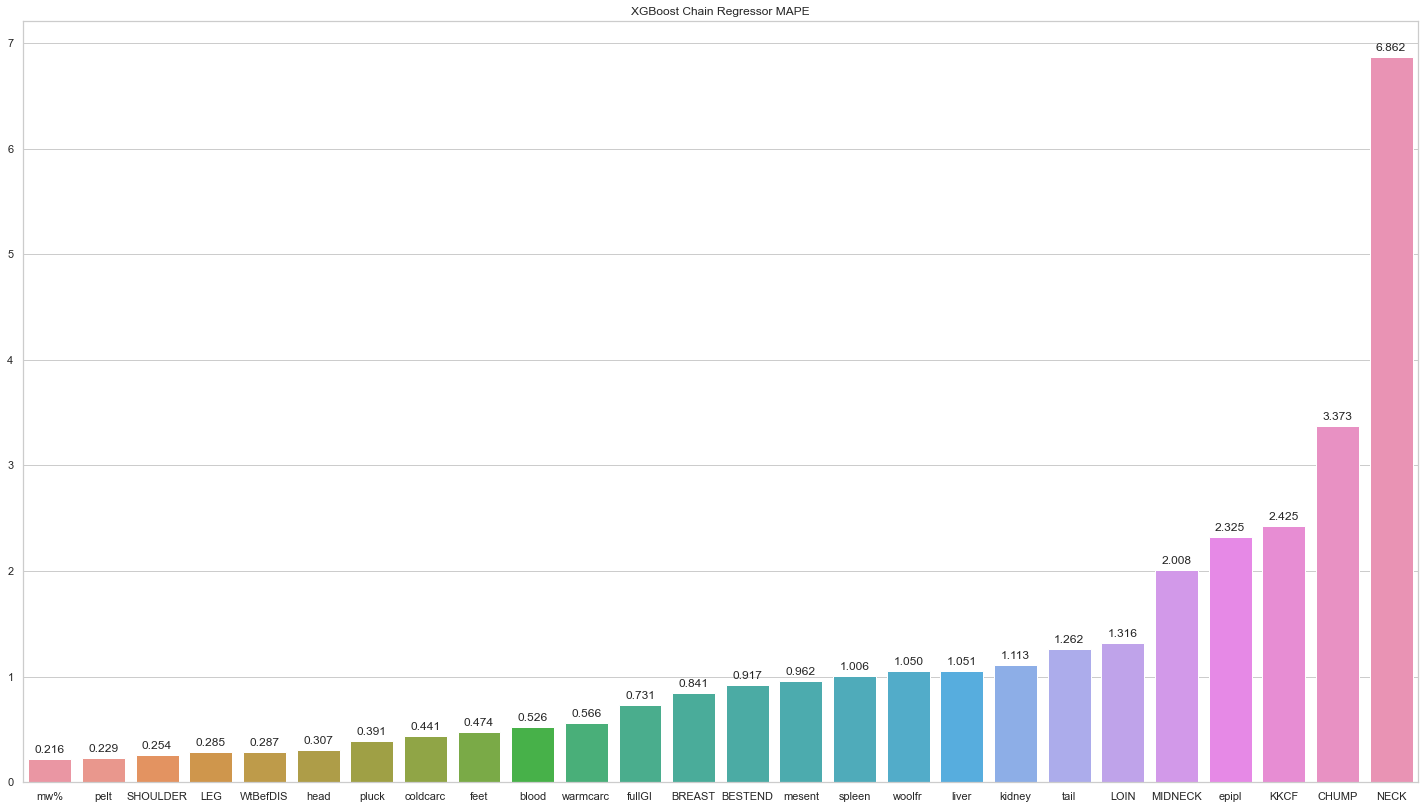

In [9]:
prediction_order = [17,24,16,15,11,10,3,22,2,21,7,9,18,1,20,0,23,8,19,14,6,5,12,4,25,13]
model = RegressorChain(LinearRegression(), order=prediction_order)
model.fit(X_train, y_train)
scores = mo_reg_scorer(model, X_test, y_test)

# Print model scores (uniform average)
print_scores(scores, 'Linear Regression Chain')
scores_barplot(scores['rv_scores_mape'], y.columns, title="XGBoost Chain Regressor MAPE")

XGBoost Chain
R2 score: 0.8286015532091716
MAE: 0.22750199010840474
RMSE: 0.3101387526881391
MAPE: 1.3331721940377483



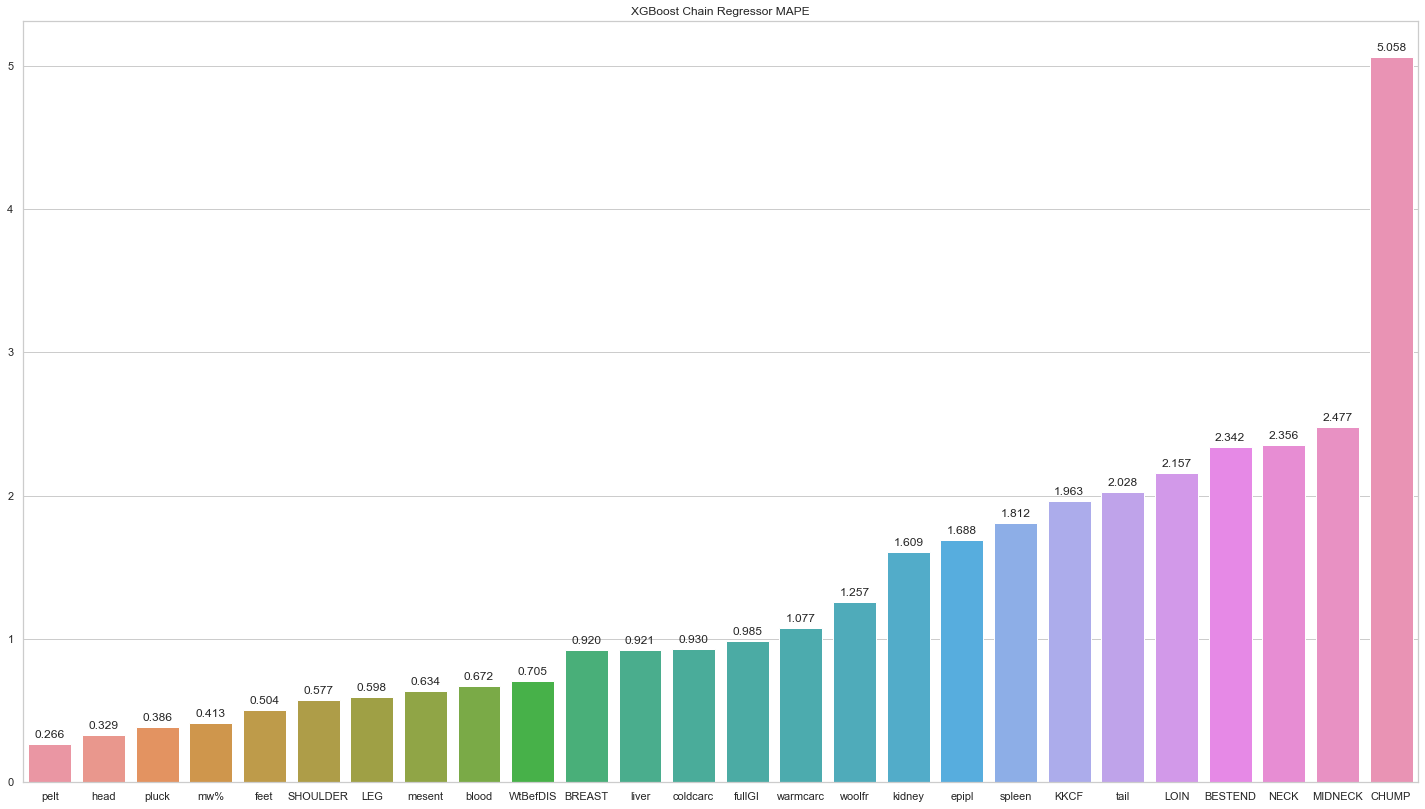

In [10]:
prediction_order = [16,17,24,15,11,10,3,21,1,20,7,22,6,0,2,23,9,18,4,5,8,14,25,12,19,13]
model = RegressorChain(xgb.XGBRegressor(colsample_bytree=0.5, learning_rate=0.1, max_depth=4,
                                        n_estimators=90, n_jobs=-1), order=prediction_order)
model.fit(X_train, y_train)
scores = mo_reg_scorer(model, X_test, y_test)

# Print model scores (uniform average)
print_scores(scores, 'XGBoost Chain')
scores_barplot(scores['rv_scores_mape'], y.columns, title="XGBoost Chain Regressor MAPE")

* Ο Linear Regression δεν παρουσιάζει κάποια βελτίωση με χρήση του chain regressor.
* Ο XGBoost παρουσιάζει μιά μικρή μείωση του MAPE απο 1.3655 σε 1.3331 με χρήση του chain regressor.